In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from tensorflow.keras.initializers import RandomNormal
from PIL import Image
import sys

from IPython import display

In [2]:
class_path = 'E:\Learning\ML_HW\Project\img_align_celeba\img_align_celeba'
# class_path = 'E:\Learning\ML_HW\Project/bedroom'
n = 0
k = 64
Num = 10000
data_set = np.zeros((Num,k,k,3))
for img_name in os.listdir(class_path):
    img_path = class_path + "/" + img_name    #每张图片地址
    img = Image.open(img_path)
    img = img.resize((k, k), Image.ANTIALIAS)     #将图片更改后的大小

    data_set[n] = img

    n+=1
    if n == Num:
        break

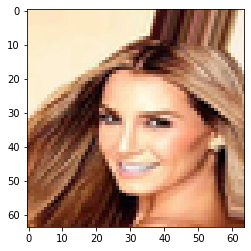

In [3]:
plt.imshow(data_set[0].astype(int))

In [4]:
import os
path = "E:/Learning/ML_HW/Project/w_test"
os.chdir(path)
os.getcwd()

'E:\\Learning\\ML_HW\\Project\\w_test'

In [5]:
train_images = data_set.astype('float32')
# Normalize the images to [-1, 1]
train_images = (train_images - 127.5) / 127.5 

In [6]:
BUFFER_SIZE = Num
BATCH_SIZE = 64

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [7]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((4, 4, 512)))
    assert model.output_shape == (None, 4, 4, 512) 

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 3)

    return model

In [8]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [9]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [10]:
# -1 for real, 1 for fake
def D_wasserstein_loss(real_output, fake_output):
    D_loss = -tf.reduce_mean(real_output - fake_output)
    return D_loss


In [11]:
def G_wasserstein_loss(fake_output):
    G_loss = -tf.reduce_mean(fake_output)
    return G_loss

In [12]:
generator_optimizer = tf.keras.optimizers.RMSprop(5e-5)  #5e-5
discriminator_optimizer = tf.keras.optimizers.RMSprop(5e-5)

In [13]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [14]:
EPOCHS = 1000
noise_dim = 100
num_examples_to_generate = 16

g_loss = []
d_loss = []

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [15]:
@tf.function
def train_step(images):
    BATCH_SIZE = images.shape[0]
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    n_critic = 5
    c = 0.01
    for _ in range(n_critic):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = generator(noise, training=True)

            real_output = discriminator(images, training=True)
            fake_output = discriminator(generated_images, training=True)

            gen_loss = G_wasserstein_loss(fake_output)
            disc_loss = D_wasserstein_loss(real_output, fake_output)   
            
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        
        for i in range(len(discriminator.trainable_variables)):
            discriminator.trainable_variables[i].assign(tf.clip_by_value(discriminator.trainable_variables[i], -c, c))
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    return gen_loss, disc_loss

In [16]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            gl, dl = train_step(image_batch)
            
        g_loss.append(float(gl))
        d_loss.append(float(dl))

        display.clear_output(wait=True)
        generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model
        if (epoch + 1) % 20 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            
            
        tf.print ('gen_loss:', gl,'disc_loss',dl, output_stream=sys.stdout)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)

In [17]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.array(predictions[i]* 127.5 + 127.5).astype(int))
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch+1))
    plt.show()

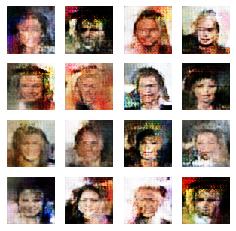

In [18]:
train(train_dataset, EPOCHS)

In [19]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [20]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [21]:
anim_file = 'wgan_lr.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


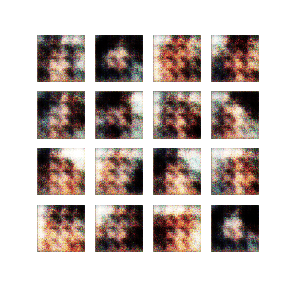

In [22]:
import IPython
display.Image(filename=anim_file)

In [24]:
g = "\n".join(str(v) for v in g_loss)
fileObject = open('G_loss.txt', 'w')
fileObject.write(g)
fileObject.close()

d = "\n".join(str(v) for v in d_loss)
fileObject = open('D_loss.txt', 'w')
fileObject.write(d)
fileObject.close()

In [33]:
gg = g_loss

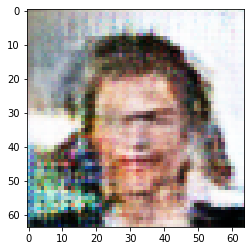

In [25]:
predictions = generator(seed, training=False)
plt.imshow(np.array(predictions[6]* 127.5 + 127.5).astype(int))

In [28]:
import os
path = "E:/Learning/ML_HW/Project/WGAN_bedroom"
os.chdir(path)
os.getcwd()

'E:\\Learning\\ML_HW\\Project\\WGAN_bedroom'

In [26]:
file_obj = open("D_loss.txt")
all_lines = file_obj.readlines()
dl = []
for line in all_lines:
    a = line.rstrip()
    dl.append(float(a))
#     print(line)
#     break
file_obj.close()


In [27]:
file_obj = open("G_loss.txt")
all_lines = file_obj.readlines()
gl = []
for line in all_lines:
    a = line.rstrip()
    gl.append(float(a))
#     print(line)
#     break
file_obj.close()

In [28]:
x = np.linspace(1, 1000, 1000, endpoint=True)

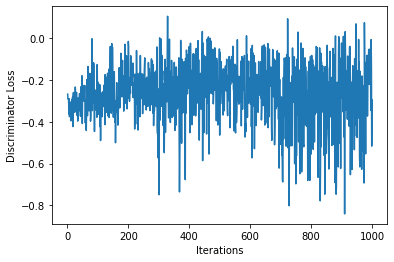

In [30]:
# plt.plot(x, dl[:1000])
fig = plt.figure()
fig = fig.add_subplot(111)
fig.plot(x, dl)
fig.set_ylabel('Discriminator Loss')
fig.set_xlabel('Iterations')
plt.show()

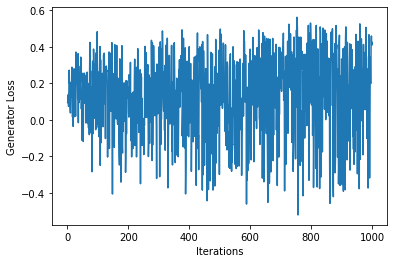

In [31]:
fig = plt.figure()
fig = fig.add_subplot(111)
fig.plot(x, gl)
fig.set_ylabel('Generator Loss')
fig.set_xlabel('Iterations')
plt.show()

In [36]:
dd = abs(np.array(d_loss))

In [38]:
np.where(min(dd))

(array([0], dtype=int64),)

In [44]:
dd.argmin()

468

In [45]:
gg = abs(np.array(g_loss))

In [47]:
gg.argmin()

391